# **Подключение библиотек**

In [87]:
import warnings
warnings.filterwarnings('ignore')

import math, time, datetime
from math import sqrt
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt
import missingno as msno
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (mutual_info_classif, SelectKBest, chi2, RFE, RFECV)

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error

# **Чтение файлов CSV**

In [52]:
df_first = pd.read_csv("/content/drive/MyDrive/sales_train.csv")
df_test_first = pd.read_csv("/content/drive/MyDrive/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")
df_items = pd.read_csv("/content/drive/MyDrive/items.csv")
df_items_cat = pd.read_csv("/content/drive/MyDrive/item_categories.csv")
df_shops = pd.read_csv("/content/drive/MyDrive/shops.csv")

Просмотрим что находится в каждом файле

In [53]:
df_first.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [9]:
df_test_first.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [10]:
df_sample_sub.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [11]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [12]:
df_items_cat.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [13]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


# **Предобработка**

In [54]:
df_first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Построим график пропущенных значений

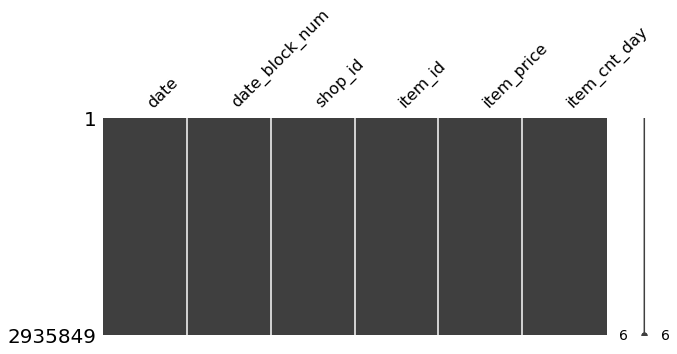

In [55]:
msno.matrix(df_first, figsize=(10, 4))

Проверка отсутствующих значений

In [16]:
df_first.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

**Удаление ненужные колонок**

In [56]:
df_dropped = df_first.drop(['date','item_price'], axis=1)
df_dropped.head(3)

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0


In [57]:
df_forecast_dropped = df_test_first.drop(['ID'], axis=1)
df_forecast_dropped.head(3)

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233


# **Создание датасета для обучения и тестирования**

Группировка по столбцам

In [58]:
df_group = df_dropped.groupby(['date_block_num', 'shop_id', 'item_id']).sum().reset_index()
df_group.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


Создаем датасет из предыдущей таблицы 

In [59]:
df_train = df_group.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', 
fill_value=0)
df_train.reset_index(inplace=True)
df_train.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Объединяем тестовый файл с тренировочным по общим столбцам для удобного тестирования 

In [60]:
df_test = pd.merge(df_forecast_dropped, df_train, on=['shop_id','item_id'], how='left').fillna(0)
df_test.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Регрессия и ресультаты** 

**Разделения на x и y**

In [61]:
X = df_train[df_train.columns[:-1]].values
y = df_train[df_train.columns[-1]]
print(X.shape)
print(y.shape)

(424124, 35)
(424124,)


Разделение датасета на тренировочный и тестовый

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(X_train.shape)
print(X_test.shape)


(360505, 35)
(63619, 35)


# **Запуск моделей машинного обучения**

**Логическая регресия**

In [65]:
log_reg = LogisticRegression().fit(X_train, y_train)

In [66]:
y_log_reg = log_reg.predict(X_test)
print("R^2 = ", log_reg.score(X, y))
print("MSE = ", mean_squared_error(y_test, y_log_reg))
print("RMSE = ", mean_squared_error(y_test, y_log_reg, squared = False))
print("MAE = ", mean_absolute_error(y_test, y_log_reg))

R^2 =  0.9257740660750158
MSE =  2.7023845077728352
RMSE =  1.643893094995181
MAE =  0.16540656093305459


**Stochastic Gradient Descent**

In [67]:
SGDC_reg = SGDClassifier().fit(X_train, y_train)

In [68]:
y_SGDC_reg = SGDC_reg.predict(X_test)
print("R^2 = ", SGDC_reg.score(X, y))
print("MSE = ", mean_squared_error(y_test, y_SGDC_reg))
print("RMSE = ", mean_squared_error(y_test, y_SGDC_reg, squared = False))
print("MAE = ", mean_absolute_error(y_test, y_SGDC_reg))

R^2 =  0.9119667832992238
MSE =  5.542573759411496
RMSE =  2.354267138497986
MAE =  0.17839010358540688


**DecisionTreeClassifier**

In [78]:
dtc_reg = DecisionTreeClassifier().fit(X_train, y_train)

In [79]:
y_dtc_reg = dtc_reg.predict(X_test)
print("R^2 = ", dtc_reg.score(X, y))
print("MSE = ", mean_squared_error(y_test, y_dtc_reg))
print("RMSE = ", mean_squared_error(y_test, y_dtc_reg, squared = False))
print("MAE = ", mean_absolute_error(y_test, y_dtc_reg))

R^2 =  0.9850892663466345
MSE =  1.986057624294629
RMSE =  1.409275567195653
MAE =  0.18392304185856426


**RandomForestRegressor**

In [76]:
rfr_reg = RandomForestRegressor().fit(X_train, y_train)

In [77]:
y_rfr_reg = rfr_reg.predict(X_test)
print("R^2 = ", rfr_reg.score(X, y))
print("MSE = ", mean_squared_error(y_test, y_rfr_reg))
print("RMSE = ", mean_squared_error(y_test, y_rfr_reg, squared = False))
print("MAE = ", mean_absolute_error(y_test, y_rfr_reg))

R^2 =  0.7818267044859366
MSE =  3.763622645750483
RMSE =  1.94000583652485
MAE =  0.17335685880004403


# **Получение результатов**

In [82]:
X_forecast = df_test[df_test.columns[:-1]].values
y_forecast_pred = dtc_reg.predict(X_forecast)
y_forecast_pred = list(map(round, y_forecast_pred))

In [83]:
y_forecast_pred[:20]

[0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 3, 0, 0, 0, 2, 6, 1, 0, 2, 0]

Создадим датафрейм по типу sample_submission

In [84]:
submission = pd.DataFrame()
submission['ID'] = df_test_first['ID']
submission['item_cnt_month'] = y_forecast_pred
submission.head()

,ID,item_cnt_month
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1


Создание файла

In [86]:
from google.colab import drive
drive.mount('/content/gdrive')
submission.to_csv('/content/gdrive/My Drive/predict_future_sales.csv', index=False)

Mounted at /content/gdrive
